In [1]:
import pennylane as qml
import jax
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
from scipy.sparse.linalg import eigsh
import optax


from unicirc import compile_adapt, count_clifford
from unicirc import matrix_v2, make_cost_fn, make_optimization_run, compile, ansatz_specs, sample_from_group

# Anthracene

In [ ]:
filename = 'data/anthracene_6' # 'pentacene_16'
n_epochs = 10_000
n_thetas = 5
optimizer_name = "lbfgs"
lr = None
tol = 1e-10
seed = 1

Us2 = np.load(filename + ".npz", allow_pickle=True)["arr_0"]

Us = []
for U_i in Us2:
    n = int(np.ceil(np.log(len(U_i))/np.log(2)))
    U = np.eye(2**n, dtype=complex)
    U[:U_i.shape[0], :U_i.shape[1]] = U_i
    Us.append(U)

Us = np.array(Us, dtype=complex)
Us.shape

(19, 8, 8)

In [3]:
# will take a while, best to run in the accompanying script

# optimizer = optax.lbfgs(learning_rate=lr, memory_size=100)

# for jjj, U in enumerate(Us):
#     print(f"Compiling unitary {jjj+1} / {len(Us)}\n")
#     energies, thetas, num_cz = compile_adapt(U,
#         "SU",
#         optimizer,
#         n_epochs,
#         num_czs=range(9, 15),
#         max_attempts_per_num_cz=n_thetas,
#         tol=tol,
#         max_const=0,
#         progress_bar=False,
#         num_records=500,
#         seed=seed,)

#     results_name = filename + f"_results_n-{n}_epochs-{n_epochs}_thetas-{n_thetas}_{optimizer_name}-{lr}_seed-{seed}_{jjj}"
#     results = {"energy": energies, "thetas": thetas, "num_cz": num_cz}
#     print(f"saving under {results_name}")
#     np.savez(results_name + ".npz", **results)

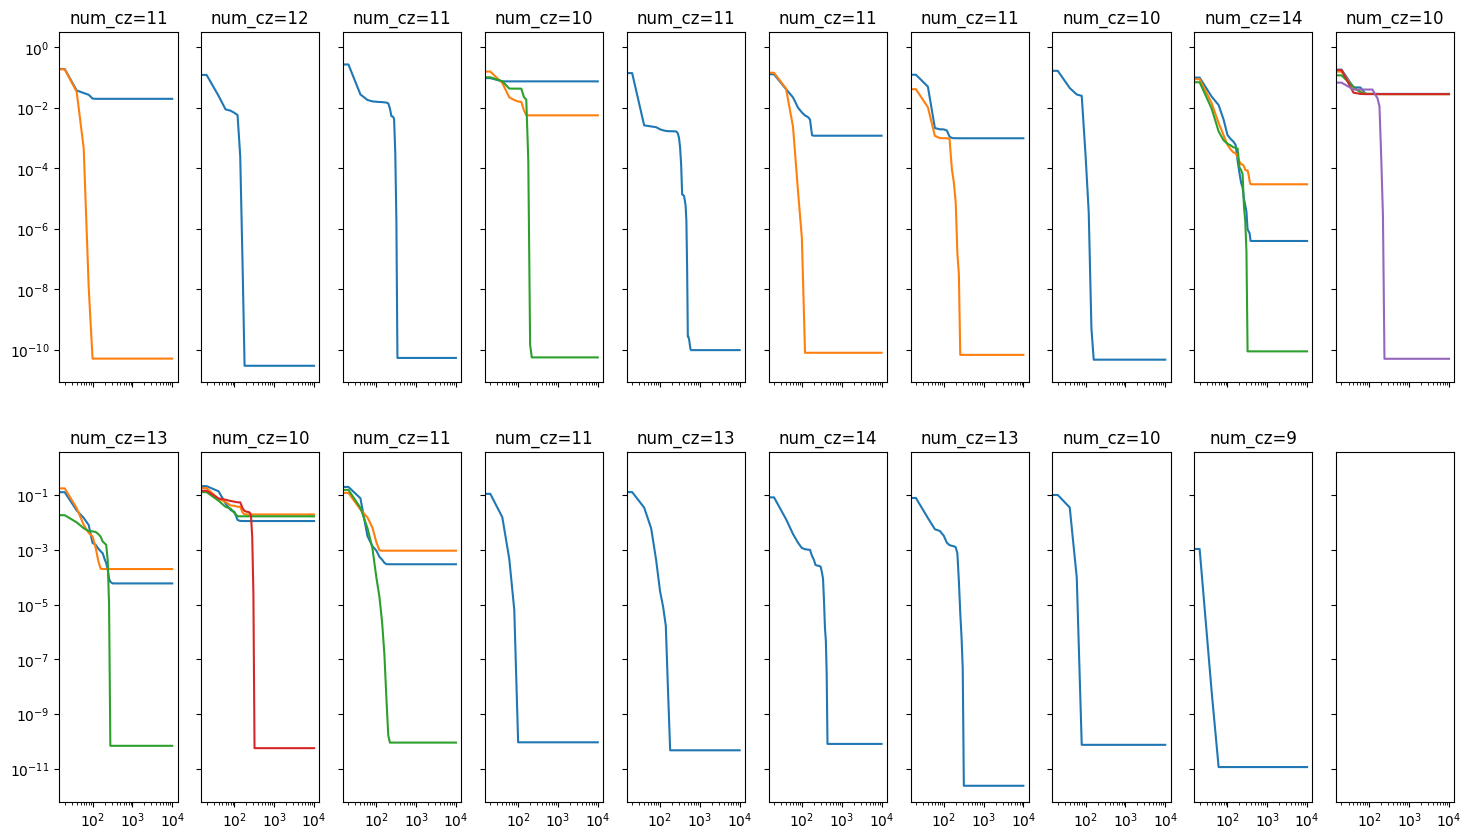

In [ ]:
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(18, 10), sharey="row", sharex=True)

for jjj in range(19):
    dat = np.load(f'data/anthracene_6_results_n-3_epochs-10000_thetas-5_lbfgs-None_seed-1_{jjj}.npz', allow_pickle=True)
    energies = dat["energy"]
    num_cz = dat["num_cz"].item()
    theta = dat["thetas"]
    ax = axs[jjj//10, jjj % 10]
    for e in energies:
        ax.plot(e[:, 0], e[:, 1])
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(f"{num_cz=}")

Text(0.5, 1.0, 'anthracene; avg: 41 $\\pm$ 13')

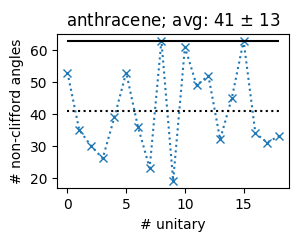

In [ ]:
non_cliffss = []
for jjj in range(19):
    dat = np.load(f'data/anthracene_6_results_n-3_epochs-10000_thetas-5_lbfgs-None_seed-1_{jjj}.npz', allow_pickle=True)
    thetas = dat["thetas"][0]
    cliffs, non_cliffs, zeros = count_clifford(thetas)
    non_cliffss.append(non_cliffs)

mean = np.mean(non_cliffss)
std = np.std(non_cliffss)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(non_cliffss, "x:")
ax.hlines(63, 0, 18, color="k")
ax.hlines(mean, 0, 18, color="k", linestyles="dotted")
ax.set_xlabel("# unitary")
ax.set_ylabel("# non-clifford angles")
ax.set_title(f"anthracene adapt; avg: {mean:.0f} $\\pm$ {std:.0f}")

In [6]:
from functools import partial

group = "SU"

d, *_ = ansatz_specs(n, group)
optimizer = optax.lbfgs(learning_rate=None, memory_size=5 * d)

matrix_fn = matrix_v2(n, group)
cost_fn = make_cost_fn(matrix_fn)
run_optimization = make_optimization_run(cost_fn, optimizer)

opt_run = jax.jit(
    partial(
        run_optimization,
        n_epochs=n_epochs,
        tol=tol,
        max_const=0,
        progress_bar=False,
        num_records=n_epochs//2,
    )
)

non_cliffs_full = []
for ii, U in enumerate(Us):
    target_dag = U.conj().T

    energies, thetas, successful = compile(d, partial(opt_run, target_dag=target_dag), key=seed, tol=tol, max_attempts=100)

    assert successful, "run {ii} not successful"
    cliffs, non_cliffs, zeros = count_clifford(thetas[-1])
    non_cliffs_full.append(non_cliffs)
    # print(f"number of non-clifford angles using full ansatz: {non_cliffs}")

Text(0.5, 1.0, 'anthracene; avg: 55 $\\pm$ 8')

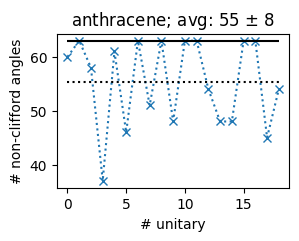

In [ ]:
mean = np.mean(non_cliffs_full)
std = np.std(non_cliffs_full)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(non_cliffs_full, "x:")
ax.hlines(63, 0, 18, color="k")
ax.hlines(mean, 0, 18, color="k", linestyles="dotted")
ax.set_xlabel("# unitary")
ax.set_ylabel("# non-clifford angles")
ax.set_title(f"anthracene full; avg: {mean:.0f} $\\pm$ {std:.0f}")

# Pentacene

In [ ]:
filename = 'data/pentacene_16'
n_epochs = 10_000
n=4
n_thetas = 5
optimizer_name = "lbfgs"
tol = 1e-10
seed = 1

Us2 = np.load(filename + ".npz", allow_pickle=True)["arr_0"]

Us = []
for U_i in Us2:
    n = int(np.ceil(np.log(len(U_i))/np.log(2)))
    U = np.eye(2**n, dtype=complex)
    U[:U_i.shape[0], :U_i.shape[1]] = U_i
    Us.append(U)

Us = np.array(Us, dtype=complex)
Us.shape

(172, 16, 16)

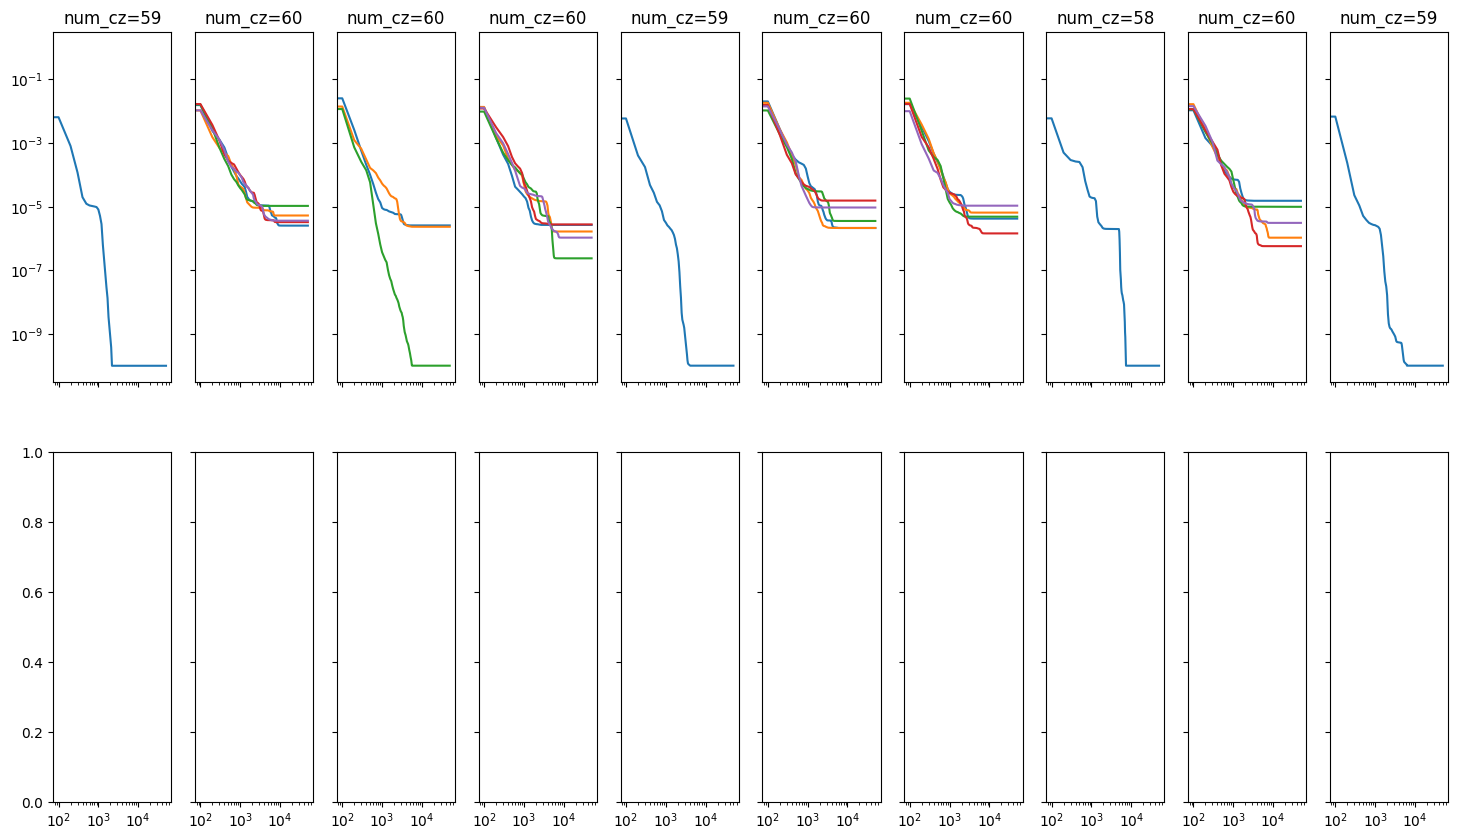

In [ ]:
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(18, 10), sharey="row", sharex=True)

for jjj in range(10):
    dat = np.load(f'data/pentacene_16_results_n-4_epochs-50000_thetas-5_lbfgs-None_seed-1_{jjj}.npz', allow_pickle=True)
    energies = dat["energy"]
    num_cz = dat["num_cz"].item()
    theta = dat["thetas"]
    ax = axs[jjj//10, jjj % 10]
    for e in energies:
        ax.plot(e[:, 0], e[:, 1])
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(f"{num_cz=}")

Text(0.5, 1.0, 'pentacene; avg: 240 $\\pm$ 15')

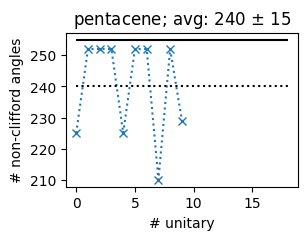

In [ ]:
non_cliffss = []
for jjj in range(10): # DATA INCOMPLETE ATM NEEDS ALL RUNS TO FINISH
    dat = np.load(f'data/pentacene_16_results_n-4_epochs-50000_thetas-5_lbfgs-None_seed-1_{jjj}.npz', allow_pickle=True)
    thetas = dat["thetas"][0]
    cliffs, non_cliffs, zeros = count_clifford(thetas)
    non_cliffss.append(non_cliffs)

mean = np.mean(non_cliffss)
std = np.std(non_cliffss)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(non_cliffss, "x:")
ax.hlines(255, 0, 18, color="k")
ax.hlines(mean, 0, 18, color="k", linestyles="dotted")
ax.set_xlabel("# unitary")
ax.set_ylabel("# non-clifford angles")
ax.set_title(f"pentacene; avg: {mean:.0f} $\\pm$ {std:.0f}")

In [ ]:
# takes about an hour to run
from functools import partial

group = "SU"

d, *_ = ansatz_specs(n, group)
optimizer = optax.lbfgs(learning_rate=None, memory_size=5 * d)

matrix_fn = matrix_v2(n, group)
cost_fn = make_cost_fn(matrix_fn)
run_optimization = make_optimization_run(cost_fn, optimizer)

opt_run = jax.jit(
    partial(
        run_optimization,
        n_epochs=n_epochs,
        tol=tol,
        max_const=0,
        progress_bar=False,
        num_records=n_epochs//2,
    )
)

non_cliffs_full = []
for ii, U in enumerate(Us):
    target_dag = U.conj().T

    energies, thetas, successful = compile(d, partial(opt_run, target_dag=target_dag), key=seed, tol=tol, max_attempts=100)

    assert successful, f"run {ii} not successful"
    cliffs, non_cliffs, zeros = count_clifford(thetas[-1])
    non_cliffs_full.append(non_cliffs)
    # print(f"number of non-clifford angles using full ansatz: {non_cliffs}")

Text(0.5, 1.0, 'penthacene full; avg: 253 $\\pm$ 5')

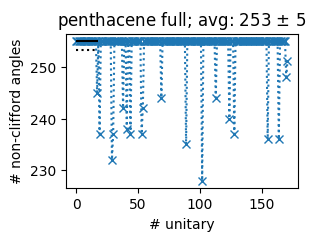

In [21]:
mean = np.mean(non_cliffs_full)
std = np.std(non_cliffs_full)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(non_cliffs_full, "x:")
ax.hlines(255, 0, 18, color="k")
ax.hlines(mean, 0, 18, color="k", linestyles="dotted")
ax.set_xlabel("# unitary")
ax.set_ylabel("# non-clifford angles")
ax.set_title(f"penthacene full; avg: {mean:.0f} $\\pm$ {std:.0f}")